# Analisis of the Relationship Between Home Price and Walk/Bikeability

<span style="font-size: 15px;">ECO225 Project 1 2024 By Samuel Ahn</span>
<span style="font-size: 15px;">1009008967, ahnsamue, sam.ahn@mail.utoronto.ca</span>

## Introduction:

## Data Cleaning/Loading:

In [155]:
#import libraries   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import display, HTML

In [156]:
#read dataset and convert into a dataframe object
realtor= pd.read_csv("realtor-data.csv")
df=realtor.copy()

In [158]:
#Adding a dummy variable representing if a house has been sold before
df["sold_before"]=np.where(df.prev_sold_date.isnull(),0,1)
#creating new column in dataframe represinting log price values
df['price'] = df['price'].apply(lambda x: np.nan if x <= 0 else x)
df['log_price'] = np.log(df['price'])
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price,sold_before,log_price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0,0,11.561716
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0,0,11.289782
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0,0,11.112448
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0,0,11.884489
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0,0,11.082143


These data include 11 columns, with 1401066 rows. The columns can be broken into two categories: location, and characteristics of the property. The locations category will be useful later in the report when grouping entries, and the characteristics will be useful for modeling and predicting our important Y-variable, price. 

## Summary Statistics Tables:

In [162]:
#printing summary statistics for numerical columns
def additional_stats(data_fr):
    additional_st ={
    'Mode': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].mode().iloc[0],
    'Variance': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].var(),
    'Skewness': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].skew(),
    'Kurtosis': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].kurtosis()
    }
    return(additional_st)


summary_stats = pd.concat([df[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].describe(), pd.DataFrame(additional_stats(df)).T])

display(HTML('<div style="font-size: 20px">Table 1: Summary Statistics of Data</div>'))
display(summary_stats.T)

,count,mean,std,min,25%,50%,75%,max,Mode,Variance,Skewness,Kurtosis
bed,1184538.0,3.392347,2.051858e+00,1.0,2.000000,3.00000,4.000000,1.230000e+02,3.000000,4.210122e+00,9.236878,321.848163
bath,1206853.0,2.487426,1.873599e+00,1.0,2.000000,2.00000,3.000000,1.980000e+02,2.000000,3.510373e+00,28.002643,2490.707721
acre_lot,1043599.0,32.150131,1.249983e+03,0.0,0.120000,0.32000,1.340000,1.000000e+05,0.060000,1.562457e+06,61.960484,4293.465563
house_size,950954.0,2178.642539,3.492618e+03,4.0,1170.000000,1700.00000,2500.000000,1.450112e+06,1200.000000,1.219838e+07,117.947014,35060.803010
sold_before,1401066.0,0.510164,4.998969e-01,0.0,0.000000,1.00000,1.000000,1.000000e+00,1.000000,2.498969e-01,-0.040663,-1.998349
price,1400851.0,818665.418928,2.683162e+06,1.0,235000.000000,446900.00000,795000.000000,8.750000e+08,599000.000000,7.199357e+12,178.075271,56421.730592
log_price,1400851.0,12.969416,1.087928e+00,0.0,12.367341,13.01009,13.586097,2.058973e+01,13.303017,1.183588e+00,-0.199308,2.457970


Table 1 displays several interesting and important qualities of the data. Something immediately noticeable is the extreme skewness of every variable, but especially the price and house size variables. All variables are also extremely leptokurtic, signifying the possible presence of outliers. This point will be returned to before data-visualization begins, as the kurtosis is large enough to have a negative impact on readability of figures and plots. In terms of values and in-context analysis, it is possible that these data include information about non-single family homes, as the max values of 123 bedrooms and 198 bathrooms hints towards multi-residential buildings. Another very interesting thing to notice is the extremely small median for acre_lot given its mean and standard deviation. This again points towards the presence of extreme outliers that may need to be dealt with before visualization. The final important takeaway from these simple sample statistics is the amount of missing data. The variable with the most missing entries is house_size, followed closely by acre_lot. This may present itself as an issue in the future, and thus should be noted. 

Due to these signs of extreme outliers, a new dataframe object will be created with said outliers removed. This dataframe will be used for visualizations that are negatively impacted by the outliers. The metric used to determine an extreme outlier within this dataset will be the interquartile range (IQR). The IQR method is used instead of z-scores due to the skewed distribution of the data. An 'extreme outlier' in this paper represents a datapoint with a value for any of the 5 variables presented in Table 1 that is either below 3 IQRs from the 25th percentile, or above 3 IQRs from the 75th percentile. This should prevent removing too much of the data. 

In [163]:
#identifying which variables we would like to remove outliers for
columns_to_remove_outliers = {'bed','bath','acre_lot','price','house_size'}

#we create a version of our data without extreme outliers for plotting 
data = df.copy()

for column in columns_to_remove_outliers:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = (df[column] < (Q1 - 5 * IQR)) | (df[column] > (Q3 + 5 * IQR))
    data = data.loc[~outliers_iqr]

#printing summary statistics for new cropped data
summary_stats_no_outliers = pd.concat([data[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].describe(), pd.DataFrame(additional_stats(data)).T])

display(HTML('<div style="font-size: 20px">Table 2: Summary Statistics With Extreme Outliers Removed</div>'))
display(summary_stats_no_outliers.T)


,count,mean,std,min,25%,50%,75%,max,Mode,Variance,Skewness,Kurtosis
bed,1100993.0,3.274193,1.625795,1.0,2.000000,3.000000,4.000000,1.400000e+01,3.000000,2.643209e+00,1.448888,4.224893
bath,1123052.0,2.319578,1.186974,1.0,1.000000,2.000000,3.000000,8.000000e+00,2.000000,1.408906e+00,1.206387,2.182625
acre_lot,923204.0,0.801202,1.290239,0.0,0.110000,0.250000,0.880000,7.440000e+00,0.060000,1.664718e+00,2.688049,7.395042
house_size,874592.0,1905.798674,1112.987338,4.0,1140.000000,1634.000000,2366.000000,9.148000e+03,1200.000000,1.238741e+06,1.789189,4.829719
sold_before,1259396.0,0.534448,0.498812,0.0,0.000000,1.000000,1.000000,1.000000e+00,1.000000,2.488135e-01,-0.138121,-1.980926
price,1259183.0,597818.563785,569743.745247,1.0,235000.000000,429900.000000,749000.000000,3.595000e+06,599000.000000,3.246079e+11,2.219645,5.918705
log_price,1259183.0,12.894408,0.979682,0.0,12.367341,12.971308,13.526494,1.509505e+01,13.303017,9.597776e-01,-0.782137,2.904144


As shown in Table 2, removing the extreme outliers had an extreme effect on the skewness and kurtosis for all 5 variables. While all variables except for bath remain extremely right skewed, the amount of skew has become far more reasonable for data_visualizations. The data has also retained a very large number of entries, meaning that the 3 IQR range for classification was effective in keeping a majority of properties untouched. Interestingly, the removal of these outliers had small effects on most of the quantiles of all 5 variables, meaning that the outliers were indeed a small portion of the properties within realtor_data.csv. 

Finally, this paper is interested in the distribution of real-estate prices depended on location, thus presenting simple statistics about this information is also warranted.

In [164]:
#creating a version sorted by state for more graphing
data_by_state = data.groupby('state')
states_data = data_by_state.agg({'price': ['mean', 'count']})
display(HTML('<div style="font-size: 20px">Table 3: Mean and Number of Listed Properties for Each State</div>'))
display(states_data)

price        
                         mean   count
state                                
Connecticut     425078.663395   92096
Delaware        332979.915754    2101
Georgia         492703.600000      50
Maine           350291.945717   30304
Massachusetts   749635.314036  160854
New Hampshire   407507.976452   42678
New Jersey      559162.081813  246466
New York        669378.690787  576742
Pennsylvania    363323.591956   19319
Puerto Rico     301196.451265   23084
Rhode Island    461297.015175   28798
South Carolina   18950.000000      25
Tennessee        34900.000000      20
Vermont         355986.400320   34335
Virgin Islands  411680.919894    2272
Virginia        362064.516129      31
West Virginia    62500.000000       5
Wyoming         535000.000000       3

This table shows the summary statistics for the random sample cut from the dataframe, that will serve as the testing group for both the hedonic and machine learning models once created. This sample displays relatively similar data to the entire dataframe, and will thus serve as an effective test for the models. 

## Plots, Histograms, Figures

PHF 1

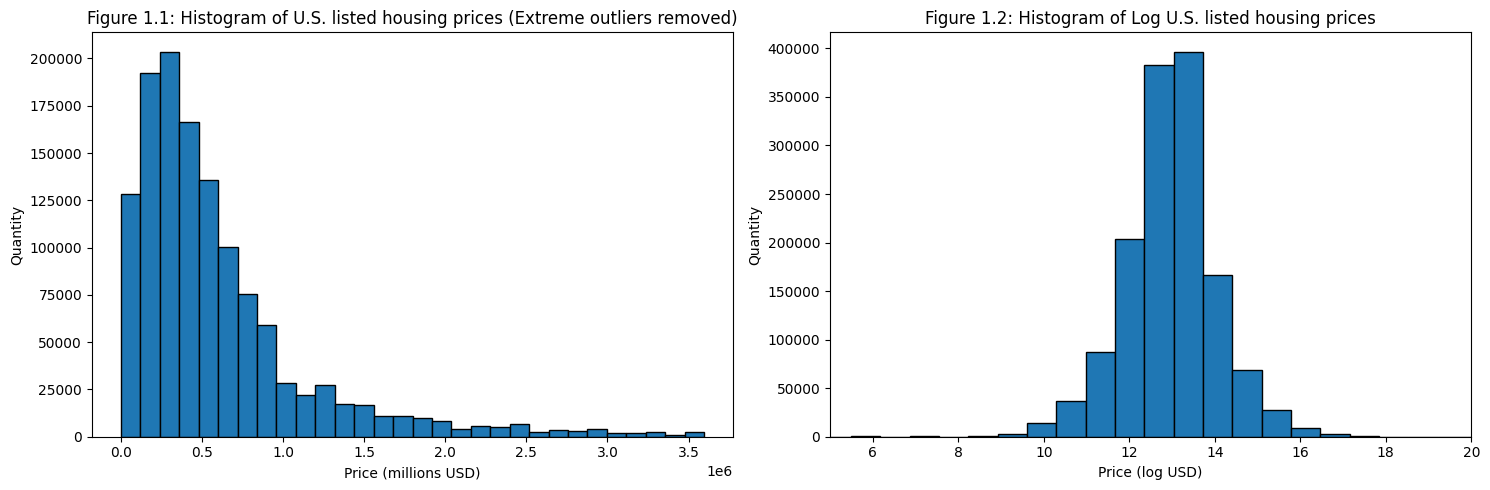

In [119]:
display(HTML('<div style="font-size: 20px">Figure 1: Price versus Log Price Distribution</div>'))

#Plotting data for price distribution
fig, fig_price = plt.subplots(1,2,figsize=(15,5))

fig_price[0].hist(data['price'],bins=30,edgecolor='black')
fig_price[0].set_title("Figure 1.1: Histogram of U.S. listed housing prices (Extreme outliers removed)")
fig_price[0].set_ylabel("Quantity")
fig_price[0].set_xlabel("Price (millions USD)")

#Plotting data for log price distribution
fig_price[1].hist(df['log_price'],bins=30,edgecolor='black')
fig_price[1].set_title("Figure 1.2: Histogram of Log U.S. listed housing prices")
fig_price[1].set_ylabel("Quantity")
fig_price[1].set_xlabel("Price (log USD)")
fig_price[1].set_xlim(5,20)

plt.tight_layout()

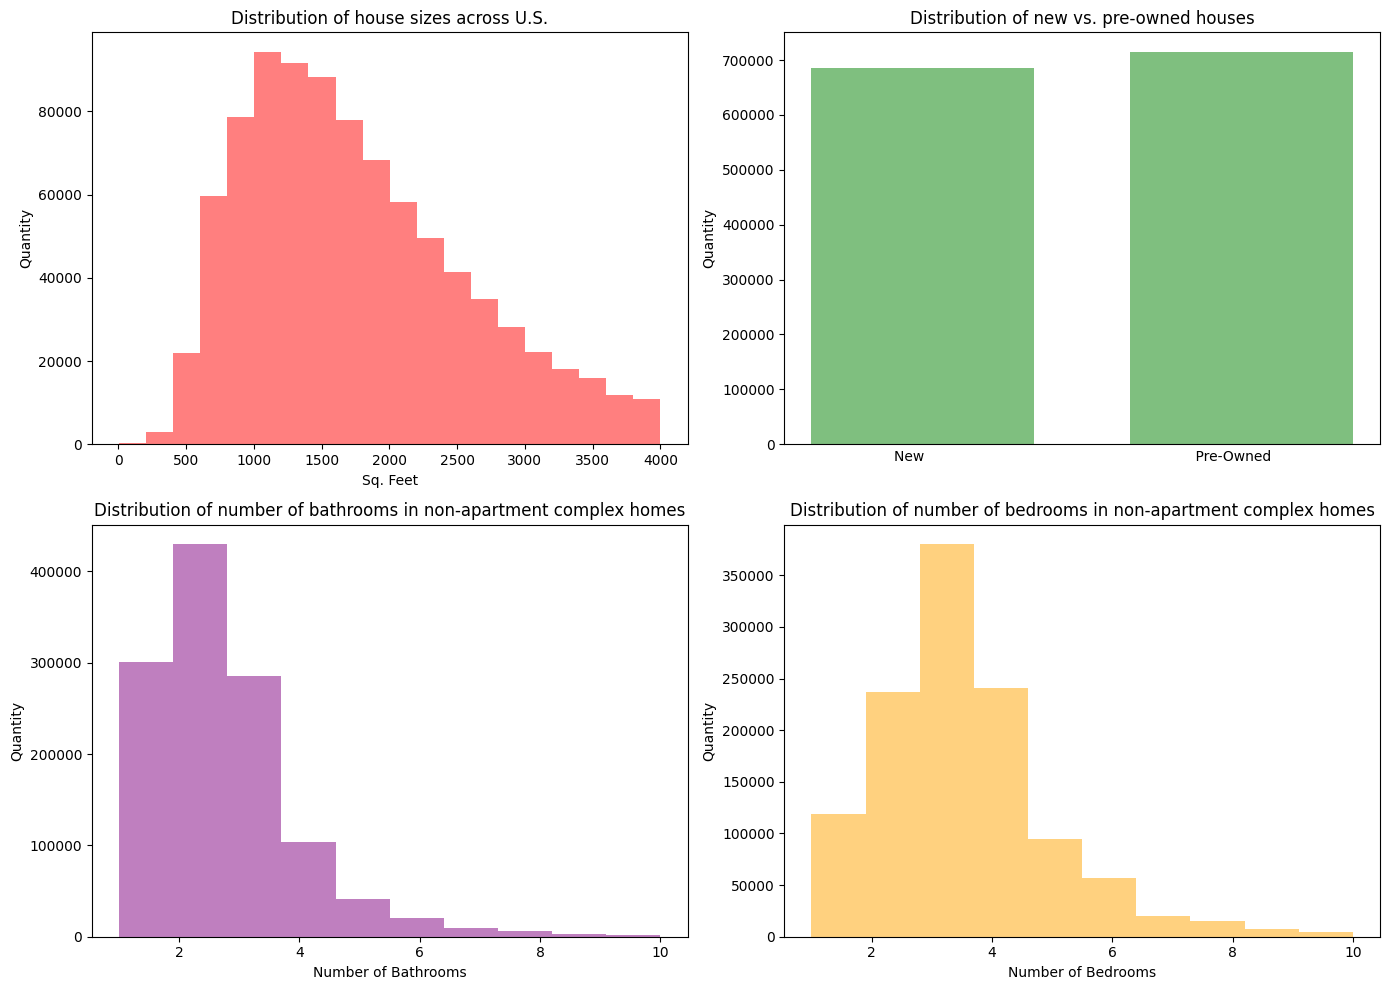

In [165]:
def plot_histogram(ax, data, bins, color, alpha, title, xlabel, ylabel, xticks=None, rwidth=None, align='mid'):
    ax.hist(data, bins=bins, color=color, alpha=alpha, rwidth=rwidth, align=align)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xticks is not None:
        ax.set_xticks(xticks)

fig, fig_1 = plt.subplots(2, 2, figsize=(14, 10))

# Plotting histogram for house_size
reasonable_homes = df['house_size'][df['house_size'] <= 4000]
plot_histogram(fig_1[0, 0], reasonable_homes, bins=20, color="red", alpha=0.5, 
               title="Distribution of house sizes across U.S.", xlabel='Sq. Feet', ylabel='Quantity')

# Plotting histogram for sold_before 
plot_histogram(fig_1[0, 1], df["sold_before"], bins=2, color="green", alpha=0.5, rwidth=0.7, align='mid', 
               title="Distribution of new vs. pre-owned houses", xlabel='New                                                              Pre-Owned', ylabel='Quantity', xticks=[])

# Plotting histogram for # of baths, limited to 10 baths to restrict apartments from being on list
baths_singlefamily = df["bath"][df["bath"] <= 10]
plot_histogram(fig_1[1, 0], baths_singlefamily, bins=10, color="purple", alpha=0.5, 
               title="Distribution of number of bathrooms in non-apartment complex homes", xlabel='Number of Bathrooms', ylabel='Quantity')

# Plotting histogram for # of bedrooms, limited to 10 baths to restrict apartments from being on list
beds_singlefamily = df["bed"][df["bed"] <= 10]
plot_histogram(fig_1[1, 1], beds_singlefamily, bins=10, color="orange", alpha=0.5, 
               title="Distribution of number of bedrooms in non-apartment complex homes", xlabel='Number of Bedrooms', ylabel='Quantity')

plt.tight_layout()

Figure 1.1 depicts the histogram for U.S. listed housing prices, with extreme outliers removed. The graph clearly shows a positively skewed distribution, with a single mode. This skewed distribution displays the large amount of homes valued between 0 USD and ~800,000 USD (75th percentile of price in unfiltered data), which make up the majority of the U.S. home market in terms of quantity. Given the large quantity of homes within this price range, it would not be unexpected to see a more competitive industry for homes under 800,000 USD vs those above 800,000 USD. This becomes more interesting when you consider the information within Figure 1.2, which shows the distribution of total market value of homes above and below the 75th percentile. Figure 1.2. Is drawn directly from the dataset, including outliers. Even though 75% of properties are valued at less than 800,000 USD, those properties only make up 33.5% of the total market value of the dataset. The high-end real estate market contains the majority of the entire market’s value. This essentially breaks the real-estate market into two distinct categories: low-end and high-end. Low-end real estate is an industry with high quantity and (relatively) low price. High-end real estate is the opposite, yet represents the greatest avenue for firm profits, considering it makes up the majority of the market value. 

Given this distribution of value, understanding how this value is decided will take up the rest of this first project.

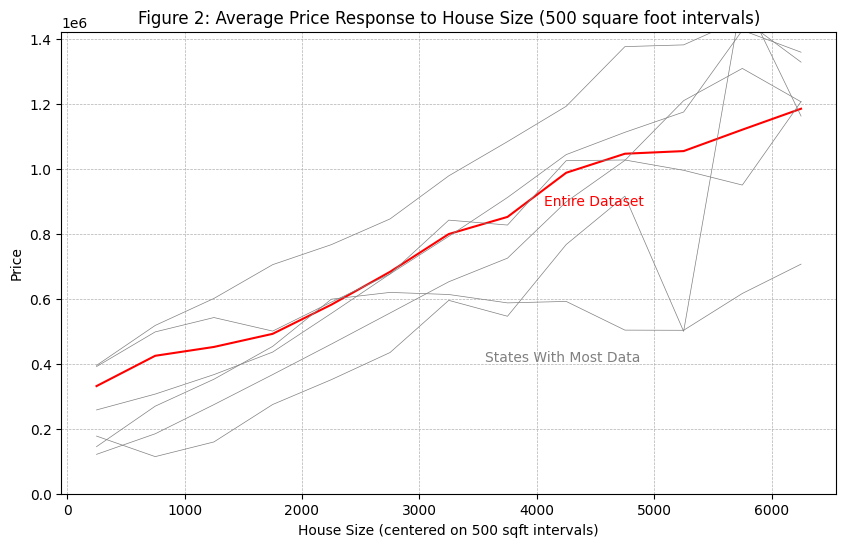

In [83]:
data['house_size_interval'] = (data['house_size'] // 500) * 500 + 250

# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the average price for the entire dataset
overall_averages = data.groupby('house_size_interval')['price'].mean().reset_index()
ax.plot(overall_averages['house_size_interval'], overall_averages['price'], color='red', label='Overall')
ax.annotate("Entire Dataset", xy=(4000,900000), xytext=(5, 0), color='red',textcoords="offset points", ha='left', va='center')
ax.annotate("States With Most Data", xy=(3500,420000), xytext=(5, 0), color='gray',textcoords="offset points", ha='left', va='center')
# Filter the DataFrame for the specified states
states_of_interest = ['New York', 'New Jersey', 'Massachusetts', 'Connecticut','Rhode Island','Puerto Rico']

# Overlay the line plots for the specified states in gray
for state in states_of_interest:
    state_df = data[data['state'] == state]
    state_averages = state_df.groupby('house_size_interval')['price'].mean().reset_index()
    line, = ax.plot(state_averages['house_size_interval'], state_averages['price'], color='gray',linewidth='0.5')

# Set the y-axis limit based on the maximum average price across all states for consistency
max_price = data.groupby('house_size_interval')['price'].mean().max()
ax.set_ylim([0, max_price * 1.2]) 

ax.set_title('Figure 2: Average Price Response to House Size (500 square foot intervals)')
ax.set_xlabel('House Size (centered on 500 sqft intervals)')
ax.set_ylabel('Price')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

This figure depicts several lines representing the average price of a home with the corresponding house size value. The red line depicts the trend for the entire dataset, with the gray lines showing several of the states with the most data. There are two key pieces of information that can be drawn from Figure 2. The first is that home price scales essentially linearly with home size. This is a very intuitive finding but still an important one nonetheless, as it proves a possible variable that can be consistently used to predict the value of a home. The second is that the trendline varies widely among states, in both value and slope. The difference in value can be explained by the difference in average price within these markets, a finding already discussed in Table 3. The difference in slope is a far more complicated finding. The fact that states show slightly different slopes means that house size has a different effect on house price for every state. This can be both a negative and positive finding, depending on how the paper ends up predicting home prices. If the paper predicts prices on a state-wide level, this is a positive, as it allows for a more comprehensive and hopefully accurate prediction. If the paper wishes to predict on a nation-wide level, this could mean a wider margin of error for predictions. 

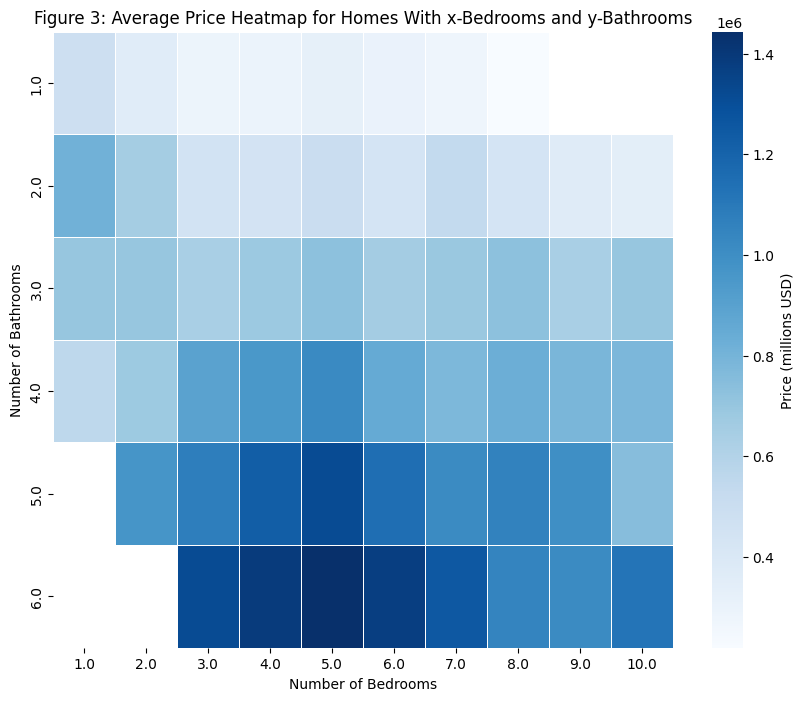

In [87]:
pivot_table_1 = data.pivot_table(values='price', index='bath', columns='bed', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
heatmap = sns.heatmap(pivot_table_1, annot=False, fmt=".0f", cmap='Blues', linewidths=.5)
plt.title('Figure 3: Average Price Heatmap for Homes With x-Bedrooms and y-Bathrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Number of Bathrooms')
color_bar = heatmap.collections[0].colorbar
color_bar.set_label('Price (millions USD)')
plt.show()

Figure 3 illustrates the interesting relationships that bedrooms and bathrooms have with price. The figure was created by calculating the average price for a home with each combination of bedrooms and bathrooms, from the dataset without extreme outliers to prevent most of the map being empty. The figure shows that the number of bathrooms essentially scales linearly with home price, with average prices rising consistently with the number of bathrooms. The interesting finding is that the number of bedrooms does not necessarily show this same property.  The average home with 10 bedrooms and 6 bathrooms is worth less than the average home with 5 bedrooms and 6 bathrooms. The ideal number of bedrooms seems to lie between 4 and 6. This presents a possible problem for predicting values of homes, as a more complex calculation involving number of bedrooms will be necessary to account for this strange finding.


<span style="font-size: 30px;">Conclusion:</span>